## ROCKET. Сравнение типов генерации ядер на Ham (UCR)
Три типа генерации ядер: normal, binary, ternary

In [33]:
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy import stats

In [48]:
DATA_FOLDER = 'data/Ham'
N_KERNELS = 7500
N_RUNS = 30
BATCH_K = 500       # количество ядер в одном батче при генерации/трансформации
BASE_SEED = 1234
OUT_DIR = 'results_ham'

os.makedirs(OUT_DIR, exist_ok=True)

In [35]:
def load_ucr_train_test(folder):
    files = os.listdir(folder)
    
    tr = [f for f in files if f.upper().endswith('_TRAIN.TXT')]
    te = [f for f in files if f.upper().endswith('_TEST.TXT')]

    if not tr or not te:
        raise FileNotFoundError("TRAIN/TEST files not found in " + folder)
    
    def read_file(path):
        df = pd.read_csv(path, header=None, sep=r'[,\s]+', engine='python')
        y = df.iloc[:,0].values
        X = df.iloc[:,1:].values.astype(float)
        return X, y
    
    Xtr, ytr = read_file(os.path.join(folder, tr[0]))
    Xte, yte = read_file(os.path.join(folder, te[0]))
    
    Xtr = np.nan_to_num(Xtr); Xte = np.nan_to_num(Xte)
    le = LabelEncoder()
    
    ytr_enc = le.fit_transform(ytr)
    yte_enc = le.transform(yte)
    
    return Xtr, ytr_enc, Xte, yte_enc, le

X_train, y_train, X_test, y_test, LABEL_ENCODER = load_ucr_train_test(DATA_FOLDER)

In [36]:
print("Loaded:", X_train.shape, X_test.shape, "classes:", np.unique(y_train))

Loaded: (109, 431) (105, 431) classes: [0 1]


In [37]:
def generate_kernel_batch(
    n_kernels, series_length, 
    kernel_type='normal', rng=None):
    
    if rng is None: rng = np.random.RandomState()
    kernels = []
    lengths = [7,9,11]
    
    for _ in range(n_kernels):
        length = int(rng.choice(lengths))
        max_dil = max(1, (series_length - 1) // (length - 1))
        if max_dil <= 1:
            dilation = 1
        else:
            max_pow = int(np.floor(np.log2(max_dil)))
            pow_choice = rng.randint(0, max_pow+1)
            dilation = 2 ** pow_choice
        if kernel_type == 'normal':
            w = rng.normal(size=length)
        elif kernel_type == 'binary':
            w = rng.choice([-1.0, 1.0], size=length)
        elif kernel_type == 'ternary':
            w = rng.choice([-1.0, 0.0, 1.0], size=length)
        else:
            raise ValueError(kernel_type)
        w = w - w.mean()
        std = w.std()
        
        if std > 0:
            w = w / std
            
        bias = float(rng.uniform(-1.0, 1.0))
        
        kernels.append({'w': w.astype(np.float32), 
                        'bias': bias, 
                        'dilation': int(dilation), 
                        'length': int(length)})
        
    return kernels


In [38]:
def transform_with_kernels_batch(X, kernels):
    n_samples, L = X.shape
    n_k = len(kernels)
    Xf = np.zeros((n_samples, n_k * 2), dtype=np.float32)
    
    for ki, k in enumerate(kernels):
        w = k['w']; b = k['bias']; d = k['dilation']; seqlen = k['length']
        out_len = L - (seqlen - 1) * d
        if out_len <= 0:
            Xf[:, 2*ki] = 0.0; Xf[:, 2*ki+1] = 0.0
            continue
        
        offsets = (np.arange(seqlen) * d).astype(np.int64)
        starts = np.arange(out_len).astype(np.int64)
        
        idx = starts[:, None] + offsets[None, :]
        windows = X[:, idx] # shape (n_samples, out_len, seqlen)
        
        conv = np.tensordot(windows, w, axes=([2],[0])) + b  # (n_samples, out_len)
        
        Xf[:, 2*ki] = conv.max(axis=1)
        Xf[:, 2*ki+1] = (conv > 0.0).mean(axis=1)
    
    return Xf


In [39]:
def compute_transform_in_batches(X, series_length, kernel_type, total_kernels, batch_k, base_seed):
    rng_global = np.random.RandomState(base_seed)
    features = []
    produced = 0
    
    while produced < total_kernels:
        cur = min(batch_k, total_kernels - produced)
        rng = np.random.RandomState(rng_global.randint(0, 2**31 - 1))
        kernels = generate_kernel_batch(cur, series_length, kernel_type=kernel_type, rng=rng)
        Xf = transform_with_kernels_batch(X, kernels)
        features.append(Xf)
        produced += cur
        
    return np.concatenate(features, axis=1) # shape (n_samples, total_kernels*2)


In [40]:
def run_one(X_train, y_train, X_test, y_test, kernel_type, n_kernels, seed):
    t0 = time.time()
    
    Xtrf = compute_transform_in_batches(X_train, X_train.shape[1], kernel_type, n_kernels, BATCH_K, seed)
    Xtef = compute_transform_in_batches(X_test, X_test.shape[1], kernel_type, n_kernels, BATCH_K, seed)
    
    t1 = time.time()
    
    clf = RidgeClassifierCV(alphas=np.logspace(-3,1,5))
    clf.fit(Xtrf, y_train)
    
    ypred = clf.predict(Xtef)
    acc = accuracy_score(y_test, ypred)
    
    return (acc, 
            {'total_time': time.time()-t0, 'transform_time': t1-t0}, 
            clf, 
            Xtrf, Xtef, 
            ypred)


In [41]:
def repeated_runs(X_train, y_train, 
                  X_test, y_test, 
                  kernel_type, n_kernels, 
                  n_runs, base_seed):
    accs = []
    times = []
    clfs = []
    last_preds = None
    
    for i in range(n_runs):
        seed = base_seed + i
        acc, tdict, clf, Xtrf, Xtef, ypred = run_one(X_train, y_train, 
                                                     X_test, y_test, 
                                                     kernel_type, 
                                                     n_kernels, 
                                                     seed)
        accs.append(acc); times.append(tdict); clfs.append(clf)
        last_preds = ypred
        print(f"[{kernel_type}] run {i+1}/{n_runs} seed={seed} acc={acc:.4f}")
        
    arr = np.array(accs)
    mean = arr.mean()
    std = arr.std(ddof=1) if n_runs>1 else 0.0
    ci_half = stats.t.ppf(0.975, df=n_runs-1) * std / np.sqrt(n_runs) if n_runs > 1 else 0.0
    
    return {'accs': arr, 'mean': mean, 'std': std, 
            'ci_half': ci_half, 'times': times, 
            'clfs': clfs, 'last_preds': last_preds}


In [45]:
TEST_NK = 200
TEST_NR = 5
kernel_types = ['normal', 'binary', 'ternary']
summary = {}
rows = []

In [46]:
for kt in kernel_types:
    print(kt)
    summary[kt] = repeated_runs(X_train, y_train, 
                                X_test, y_test, 
                                kt, TEST_NK, 
                                TEST_NR, BASE_SEED)


normal
[normal] run 1/5 seed=1234 acc=0.7143
[normal] run 2/5 seed=1235 acc=0.6857
[normal] run 3/5 seed=1236 acc=0.7619
[normal] run 4/5 seed=1237 acc=0.6476
[normal] run 5/5 seed=1238 acc=0.7143
binary
[binary] run 1/5 seed=1234 acc=0.6571
[binary] run 2/5 seed=1235 acc=0.7143
[binary] run 3/5 seed=1236 acc=0.6857
[binary] run 4/5 seed=1237 acc=0.7714
[binary] run 5/5 seed=1238 acc=0.7714
ternary
[ternary] run 1/5 seed=1234 acc=0.7524
[ternary] run 2/5 seed=1235 acc=0.7429
[ternary] run 3/5 seed=1236 acc=0.7905
[ternary] run 4/5 seed=1237 acc=0.6952
[ternary] run 5/5 seed=1238 acc=0.7048


In [47]:
for kt in kernel_types:
    r = summary[kt]
    rows.append({'kernel_type': kt, 
                 'mean_acc': r['mean'], 
                 'std_acc': r['std'], 
                 'ci_half': r['ci_half'],
                 'n_runs': len(r['accs'])})
    
df_quick = pd.DataFrame(rows)
print(df_quick)
df_quick.to_csv(os.path.join(OUT_DIR, 'quick_summary.csv'), index=False)

  kernel_type  mean_acc   std_acc   ci_half  n_runs
0      normal  0.704762  0.042056  0.052219       5
1      binary  0.720000  0.051110  0.063462       5
2     ternary  0.737143  0.038451  0.047743       5


In [49]:
kernel_types = ['normal', 'binary', 'ternary']
full_summary = {}
rows = []
for kt in kernel_types:
    print(kt)
    full_summary[kt] = repeated_runs(X_train, y_train, 
                                     X_test, y_test, 
                                     kt, N_KERNELS, 
                                     N_RUNS, BASE_SEED)

normal
[normal] run 1/30 seed=1234 acc=0.7238
[normal] run 2/30 seed=1235 acc=0.7333
[normal] run 3/30 seed=1236 acc=0.7238
[normal] run 4/30 seed=1237 acc=0.7333
[normal] run 5/30 seed=1238 acc=0.7143
[normal] run 6/30 seed=1239 acc=0.7429
[normal] run 7/30 seed=1240 acc=0.7619
[normal] run 8/30 seed=1241 acc=0.7143
[normal] run 9/30 seed=1242 acc=0.7524
[normal] run 10/30 seed=1243 acc=0.7333
[normal] run 11/30 seed=1244 acc=0.7524
[normal] run 12/30 seed=1245 acc=0.7429
[normal] run 13/30 seed=1246 acc=0.7333
[normal] run 14/30 seed=1247 acc=0.7143
[normal] run 15/30 seed=1248 acc=0.7333
[normal] run 16/30 seed=1249 acc=0.7238
[normal] run 17/30 seed=1250 acc=0.7333
[normal] run 18/30 seed=1251 acc=0.7619
[normal] run 19/30 seed=1252 acc=0.7238
[normal] run 20/30 seed=1253 acc=0.7238
[normal] run 21/30 seed=1254 acc=0.7048
[normal] run 22/30 seed=1255 acc=0.7333
[normal] run 23/30 seed=1256 acc=0.7333
[normal] run 24/30 seed=1257 acc=0.7238
[normal] run 25/30 seed=1258 acc=0.7333
[n

In [50]:
for kt in kernel_types:
    r = full_summary[kt]
    rows.append({'kernel_type': kt, 
                 'mean_acc': r['mean'],
                 'std_acc': r['std'], 
                 'ci_half': r['ci_half'], 
                 'n_runs': len(r['accs'])})
    
df_full = pd.DataFrame(rows)
df_full.to_csv(os.path.join(OUT_DIR, 'rocket_summary_full.csv'), index=False)
print(df_full)

  kernel_type  mean_acc   std_acc   ci_half  n_runs
0      normal  0.732381  0.013779  0.005145      30
1      binary  0.704127  0.011977  0.004472      30
2     ternary  0.693651  0.012773  0.004770      30


In [51]:
knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
knn.fit(X_train, y_train)
acc_knn = knn.score(X_test, y_test)

rf = RandomForestClassifier(n_estimators=400, random_state=42)
rf.fit(X_train, y_train)
print("RandomForest on raw series:", rf.score(X_test, y_test))

RandomForest on raw series: 0.7047619047619048


In [52]:
try:
    from tslearn.neighbors import KNeighborsTimeSeriesClassifier
    knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="dtw")
    # tslearn expects shape (n, sz) or (n, sz, d)
    knn_dtw.fit(X_train, y_train)
    print("1-NN (DTW):", knn_dtw.score(X_test, y_test))
except Exception as e:
    print("tslearn not available or DTW failed:", e)


tslearn not available or DTW failed: No module named 'tslearn'


In [53]:
from itertools import combinations
def paired_tests(a, b, name_a, name_b):
    # a, b - arrays of shape (n_runs,)
    t_stat, p_t = stats.ttest_rel(a, b)
    try:
        w_stat, p_w = stats.wilcoxon(a - b)
    except Exception as e:
        w_stat, p_w = np.nan, np.nan
    print(f"{name_a} vs {name_b}: paired t p={p_t:.4e}, wilcoxon p={p_w if not np.isnan(p_w) else 'NA'}")

# примеры: сравним три типа ядер между собой
if 'full_summary' in globals():
    for a,b in combinations(kernel_types,2):
        paired_tests(full_summary[a]['accs'], full_summary[b]['accs'], a, b)
else:
    print("Run full experiment first (cell 10) to have full_summary.")


normal vs binary: paired t p=1.3786e-09, wilcoxon p=3.0743481371581635e-06
normal vs ternary: paired t p=2.8938e-11, wilcoxon p=1.595254879875626e-06
binary vs ternary: paired t p=5.8633e-04, wilcoxon p=0.0019609576181684554


/var/folders/qf/xy929rcx1xnc19y51wt8zct00000gn/T/ipykernel_2504/3242207393.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=kernel_types, showmeans=True)


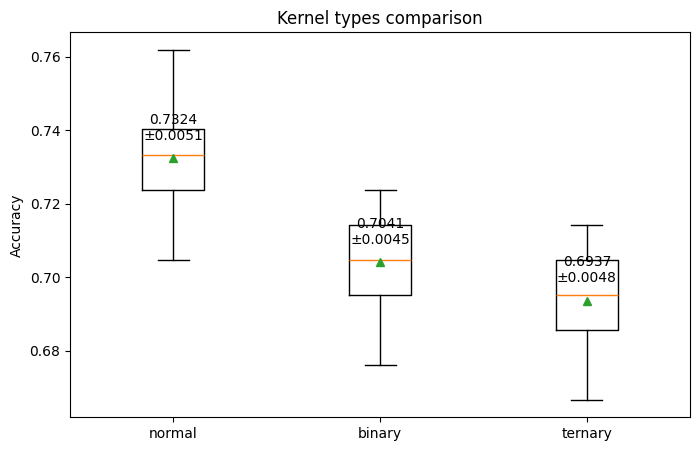

Confusion matrix (normal, last run):
 [[39 12]
 [15 39]]
              precision    recall  f1-score   support

           0       0.72      0.76      0.74        51
           1       0.76      0.72      0.74        54

    accuracy                           0.74       105
   macro avg       0.74      0.74      0.74       105
weighted avg       0.74      0.74      0.74       105

Results saved to results_ham


In [54]:
# boxplot
if 'full_summary' in globals():
    data = [full_summary[kt]['accs'] for kt in kernel_types]
    fig, ax = plt.subplots(figsize=(8,5))
    ax.boxplot(data, labels=kernel_types, showmeans=True)
    for i, kt in enumerate(kernel_types):
        m = full_summary[kt]['mean']; c = full_summary[kt]['ci_half']
        ax.text(i+1, m + 0.005, f"{m:.4f}\n±{c:.4f}", ha='center')
    ax.set_ylabel('Accuracy'); ax.set_title('Kernel types comparison')
    plt.savefig(os.path.join(OUT_DIR, 'kernel_types_boxplot.png'), dpi=150)
    plt.show()

    # confusion matrix and report for last run of 'normal' (example)
    last_preds = full_summary['normal']['last_preds']
    cm = confusion_matrix(y_test, last_preds)
    print("Confusion matrix (normal, last run):\n", cm)
    print(classification_report(y_test, last_preds, zero_division=0))
    # save full_summary to csv
    rows = []
    for kt in kernel_types:
        for i,acc in enumerate(full_summary[kt]['accs']):
            rows.append({'kernel_type': kt, 'run': i+1, 'acc': float(acc)})
    pd.DataFrame(rows).to_csv(os.path.join(OUT_DIR, 'rocket_runs_detail.csv'), index=False)
    print("Results saved to", OUT_DIR)
else:
    print("Run full experiment first.")


# Вывод и интерпретация (шаблон)
- Датасет: Ham (UCR). Train: `{}`. Test: `{}`.
- Параметры эксперимента: n_kernels = `{}`, n_runs = `{}`, batch_k = `{}`.

### Результаты (сводка)
(тут будут значения из CSV)
- Normal: среднее accuracy = `{mean_normal:.4f}` ± `{ci_normal:.4f}` (95% CI)
- Binary: среднее accuracy = `{mean_binary:.4f}` ± `{ci_binary:.4f}`
- Ternary: среднее accuracy = `{mean_ternary:.4f}` ± `{ci_ternary:.4f}`

### Сравнения
- Baselines:
  - 1-NN (Euclid) = `{acc_knn:.4f}`
  - RF on raw series = `{acc_rf:.4f}`
  - 1-NN (DTW) = `{acc_dtw}`

### Статистика
- Парный t-test и Wilcoxon между парами:
  - Normal vs Binary: p = `p_nb`
  - Normal vs Ternary: p = `p_nt`
  - Binary vs Ternary: p = `p_bt`

### Интепретация (пример)
- Если один тип ядер статистически лучше (p < 0.05) — делаем вывод о его превосходстве при данных настройках.
- Если все ~равны — выбираем тот, который быстрее (сравнить времена).
- Если качества хуже, чем в статье — проверить n_kernels, dilation policy, нормализацию входов и classifier hyperparams.
